In [147]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import random
import os
import parallel_plume_sim as pps
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
import plotly.io as py

from scipy.spatial.distance import cdist
from scipy.interpolate import splprep, splev
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
puff_data_filename = '~/An/data/Oct29Plumes/puff_data_20241029_101718.pickle'

# how many seconds to include per chunk?
max_time = 10

# maximum distance in x and y to consider puffs before ignoring them?
min_x = -5
max_x = 50
min_y = -25
max_y = 25

pps.read_puff_data.split_puff_data_into_smaller_dataframes_and_cull_old_puffs(puff_data_filename, 
                                                                              max_time, 
                                                                              min_x, max_x, 
                                                                              min_y, max_y)

Directory /home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718 exists, contains 126 files.


Removed all files in:  /home/gorilla/An/data/Oct29Plumes/puff_data_20241029_101718


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/ParallelPlumeSim_florisvb-0.0.1-py3.10.egg/parallel_plume_sim/read_puff_data.py:152: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  mdf.to_hdf(fname, 'data_puffs_' + str(n))
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/ParallelPlumeSim_florisvb-0.0.1-py3.10.egg/parallel_plume_sim/read_puff_data.py:152: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  mdf.to_hdf(fname, 'data_puffs_' + str(n))
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/ParallelPlumeSim_florisvb-0.0.1-py3.10.egg/parallel_plume_sim/read_puff_data.py:152: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  mdf.to_hdf(fname, 'data_puffs_' + str(n))
/home/gorilla/An/arunavanag/lib/python3.10/sit

In [3]:
# This should match your directory name from above -- you need to change this
dirname = '/home/gorilla/An/data/Oct29Plumes/puff_data_20241029_111917/'
# Class for reading puff data
puff_reader = pps.read_puff_data.PuffReader(dirname)

### Generate Trajectories and Collect Odor Encounters

In [ ]:
def process_position(position):
    time, x, y = position
    concentration, wind_x, wind_y = puff_reader.get_odor_concentration_at_t_and_position(time, x, y)
    return concentration, wind_x, wind_y

def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [ ]:
# def generate_trajectory(x_limits, y_limits, n_waypoints, noise_scale, n_eval_points):
#     waypoints = np.zeros((n_waypoints, 2))
    
#     ## random trajectory
#     waypoints[:, 0] = np.random.uniform(x_limits[0], x_limits[1], n_waypoints)
#     waypoints[:, 1] = np.random.uniform(y_limits[0], y_limits[1], n_waypoints)
    
#     ## adding noise
#     #waypoints += noise_scale * np.random.randn(n_waypoints, 2)  # Add noise

#     # Adding more noise
#     waypoints += 2* noise_scale * np.random.randn(n_waypoints, 2)
    
#     # Randomizing the order of waypoints
#     np.random.shuffle(waypoints)
    
#     # Generate B-Spline as before
#     tck, u = splprep(waypoints.T, s=0)
#     unew = np.linspace(0, 1.0, n_eval_points)
#     out = splev(unew, tck)

#     return out[0], out[1]


# def process_and_save_data(index, foldername):
#     n_waypoints = math.floor(random.randint(90, 200) / 10) * 10  # multiple of 10
#     n_eval_points = math.floor(random.randint(1000, 2000) / 50) * 50  # multiple of 50

#     x, y = generate_trajectory((0, 20), (0, 20), n_waypoints, 3.5, n_eval_points)
#     time = np.linspace(1, 199, len(x))

#     with multiprocessing.Pool() as pool:
#         results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

#     c = [result[0] for result in results]
#     wx = [result[1] for result in results]
#     wy = [result[2] for result in results]

#     # Processed data with encounter information
#     df_new = pd.DataFrame()
#     df_new['time'] = time  # Uncommented this line to include time in the DataFrame
#     df_new['odor'] = c
#     df_new['windx'] = wx
#     df_new['windy'] = wy
#     df_new['x'] = x
#     df_new['y'] = y

#     # Saving the processed data
#     # processed_filename = f'/home/beast/An/data/Nov6/{foldername}/diag{index}.h5'
#     processed_filename = f'/home/gorilla/An/data/Oct29Plumes/{foldername}/diag{index}.h5'
#     df_new.to_hdf(processed_filename, key='data', mode='w')

#     # Trajectory data - this is the new DataFrame that stores just the trajectory
#     df_trajectory = pd.DataFrame()
#     df_trajectory['time'] = time
#     df_trajectory['x'] = x
#     df_trajectory['y'] = y

#     # Saving the trajectory data
#     trajectory_filename = f'/home/gorilla/An/data/Oct29Plumes/{foldername}/trajectory{index}.h5'
#     df_trajectory.to_hdf(trajectory_filename, key='data', mode='w')

# for i in range(1, 105):
#     process_and_save_data(i,'train_raw')


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scipy/interpolate/_fitpack_py.py:155: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  res = _impl.splprep(x, w, u, ub, ue, k, task, s, t, full_output, nest, per,


In [5]:
def process_and_save_existing_trajectory(foldername, dfres):
    # Extract x and y from dfres
    x = dfres.distance_along_streakline.values
    y = dfres.nearest_from_streakline.values
    time = np.linspace(90, 199, len(x))  # Assuming a time array for the length of trajectory
    # time = dfres.time if time is also provided in the file

    # Process the trajectory using multiprocessing
    with multiprocessing.Pool() as pool:
        results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

    # Extract results for concentration and wind
    c = [result[0] for result in results]
    wx = [result[1] for result in results]
    wy = [result[2] for result in results]

    # Create DataFrame with encounter information
    df_new = pd.DataFrame()
    df_new['time'] = time
    df_new['odor'] = c
    df_new['windx'] = wx
    df_new['windy'] = wy
    df_new['x'] = x
    df_new['y'] = y

    # Save processed data
    processed_filename = f'/home/gorilla/An/data/Oct29Plumes/{foldername}/diag.h5'
    df_new.to_hdf(processed_filename, key='data', mode='w')

### loading plume from pps
dirname = '/home/gorilla/An/data/Oct29Plumes/puff_data_20241029_111917/'
puff_reader = pps.read_puff_data.PuffReader(dirname)
### playing desert trajectory
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5')
dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign
process_and_save_existing_trajectory('train_raw', dfres)


In [6]:
encounter = pd.read_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/diag.h5')

In [47]:
# traj=pd.read_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/trajectory1.h5')
# encounter = pd.read_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/diag.h5')
# plt.plot(traj.x,traj.y)


In [13]:
def sqrt_min_max_scale(data):
    data_sqrt = np.sqrt(data)
    min_val = np.min(data_sqrt)
    max_val = np.max(data_sqrt)
    return (((data_sqrt - min_val) / (max_val - min_val)) * 10)

def power_min_max_scale(data, exponent=0.5):
    data_power = np.power(data, exponent)
    min_val = np.min(data_power)
    max_val = np.max(data_power)
    return (((data_power - min_val) / (max_val - min_val)) * 10)

In [53]:
dt =encounter.time[1]-encounter.time[0]
time_scaled = []
time_scaled.append(0)
for i in range(1,len(encounter)):
    time_scaled.append(time_scaled[i-1]+dt)

encounter['time_scaled']=time_scaled

In [84]:
encounter['scaled_odor']=sqrt_min_max_scale(encounter.odor)

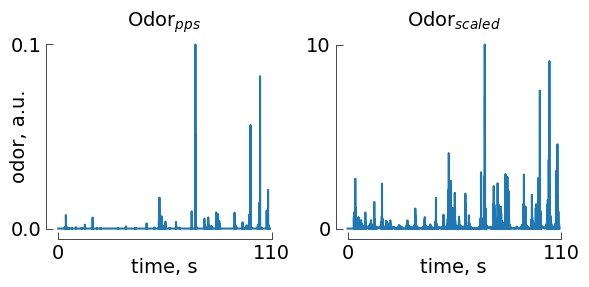

In [72]:
f, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].plot(encounter.time_scaled, encounter.odor)
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1,'bottom':1}, 
                            smart_bounds=True,
                            xticks=[0, 110],
                            yticks=[0,0.1],
                            linewidth=0.5)
ax[0].set_xlabel('time, s')
ax[0].set_ylabel('odor, a.u.')
ax[0].set_title('Odor$_{pps}$')

# Plot the scaled data in ax[1]
ax[1].plot(encounter.time_scaled, sqrt_min_max_scale(encounter.odor))
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1, 'bottom':1}, 
                            smart_bounds=True,
                            xticks=[0, 110],
                            yticks=[0, 10],
                            linewidth=0.5)
ax[1].set_xlabel('time, s')
# ax[1].set_ylabel('odor, a.u.')
ax[1].set_title('Odor$_{scaled}$')

ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
ax[0].xaxis.set_label_coords(0.5, -0.1)
ax[1].xaxis.set_label_coords(0.5, -0.1)

mpl_functions.set_fontsize(f, 14)
f.tight_layout()

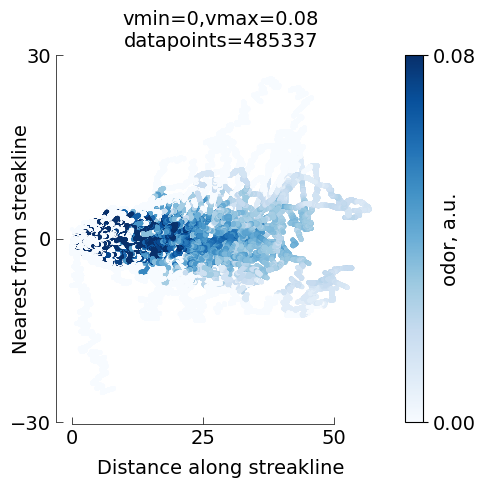

In [123]:
f,ax=plt.subplots(1,1,figsize=(5,5))
vmin = 0 
vmax = 0.08
cax = ax.scatter(encounter.x,encounter.y , c=sqrt_min_max_scale(encounter.odor),s=5, cmap='Blues', vmin=vmin,vmax=vmax)
cb1=plt.colorbar(cax)
cb1.set_label('odor, a.u.',labelpad=-25)
cb1.set_ticks([0,0.08])
ax.set_xlabel('Distance along streakline')
ax.set_ylabel('Nearest from streakline')

mpl_functions.adjust_spines(ax,['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,25,50],
                        yticks=[-30,0,30],
                        linewidth=0.5)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_title('vmin='+str(vmin)+','+'vmax='+str(vmax)+'\ndatapoints='+str(len(encounter)))
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

In [200]:
source = np.array([[0,0]])
odor_position = np.array([[encounter.x[i],encounter.y[i]] for i in range (len(encounter))]) 

distance_from_source = np.array([cdist(odor_position,source)]).flatten()
encounter['distance_from_source'] = distance_from_source

In [179]:
query='odor>0.0000001'
df = encounter.query(query)
df.reset_index(inplace=True, drop=True)

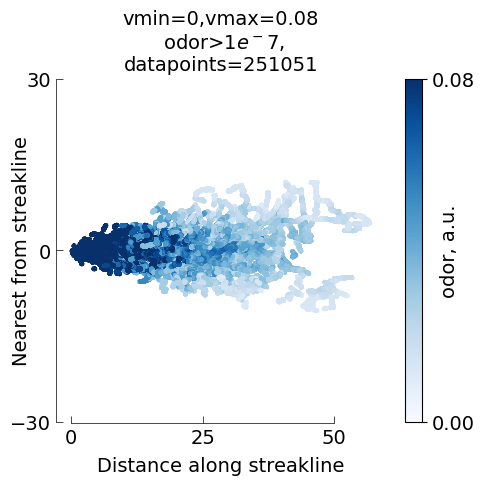

In [180]:
f,ax=plt.subplots(1,1,figsize=(5,5))
vmin = 0 
vmax = 0.08
cax = ax.scatter(df.x,df.y , c=df.scaled_odor,s=5, cmap='Blues', vmin=vmin,vmax=vmax)
cb1=plt.colorbar(cax)
cb1.set_ticks([0,0.08])
cb1.set_label('odor, a.u.',labelpad=-25)
ax.set_xlabel('Distance along streakline')
ax.set_ylabel('Nearest from streakline')

mpl_functions.adjust_spines(ax,['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,25,50],
                        yticks=[-30,0,30],
                        linewidth=0.5)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_title('vmin='+str(vmin)+','+'vmax='+str(vmax)+'\n odor>$1e^-7$,\ndatapoints='+str(len(df)))
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

In [181]:
df_predicted =pd.read_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/hws_pr.h5')

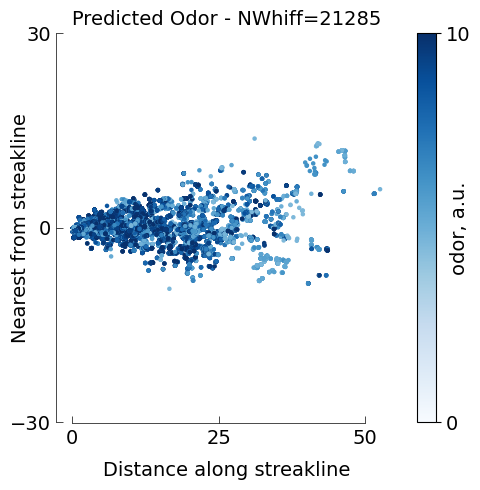

In [235]:
f,ax=plt.subplots(1,1,figsize=(5,5))
vmin = 0 
vmax = 10
cax = ax.scatter(df_predicted.distance_along_streakline,df_predicted.nearest_from_streakline , c=df_predicted.predicted_odor,s=5, cmap='Blues', vmin=vmin,vmax=vmax)
cb1=plt.colorbar(cax)
cb1.set_ticks([0,10])
cb1.set_label('odor, a.u.',labelpad=-15)
ax.set_xlabel('Distance along streakline')
ax.set_ylabel('Nearest from streakline')

mpl_functions.adjust_spines(ax,['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,25,50],
                        yticks=[-30,0,30],
                        linewidth=0.5)
ax.yaxis.set_label_coords(-0.08, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_title('Predicted Odor - NWhiff='+str(len(df_predicted)))
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

/tmp/ipykernel_752763/2467065081.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  whiff_counts_actual = df_actual.groupby('distance_bin').size()
/tmp/ipykernel_752763/2467065081.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_concentrations_actual = df_actual.groupby('distance_bin')['scaled_odor'].mean()
/tmp/ipykernel_752763/2467065081.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  whiff_counts_predict

Min of mean_concentrations_actual: 0.014050730838633592
Max of mean_concentrations_actual: 0.9639574325320314


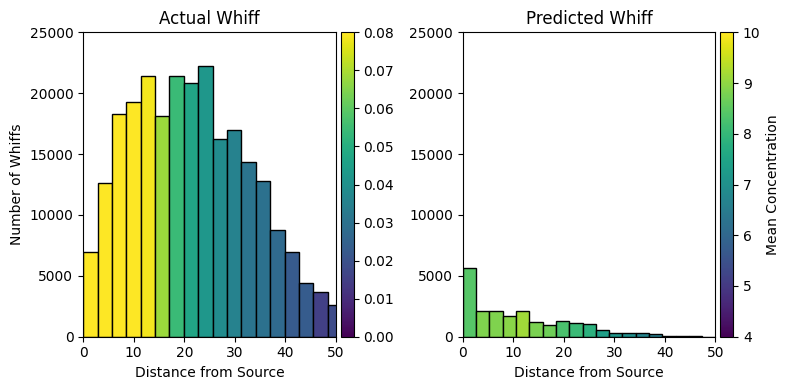

In [183]:
n_bins = 20

# Actual Whiff Data
df_actual = df.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['scaled_odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Predicted Whiff Data
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

print("Min of mean_concentrations_actual:", mean_concentrations_actual.min())
print("Max of mean_concentrations_actual:", mean_concentrations_actual.max())

# Create the subplots
f, ax = plt.subplots(1, 2, figsize=(8, 4))
upper_bound = mean_concentrations_actual.max() if mean_concentrations_actual.max() < 0.08 else 0.08
norm_actual = plt.Normalize(0, 0.08)
# Plot for Actual Whiff Data
# norm_actual = plt.Normalize(0, 0.08)
# colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
# bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)


divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Number of Whiffs')
ax[0].set_title('Actual Whiff')
ax[0].set_ylim(0,25000)
ax[0].set_xlim(0,50)

norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
ax[1].set_ylim(0,25000)
ax[1].set_xlim(0,50)
f.tight_layout()



In [184]:
import odor_stat_calculations as osc

In [204]:
def cal_stat(x,idx,df2):
    osc.avg_distance(x,idx,df2)
    osc.mean_conc(x,idx,df2)
    osc.whiff_blank_duration(x,idx,df2)
    osc.std_whiff(x,idx,df2)
    osc.mean_avg(x,idx,df2)
    osc.encounter_frequency(x,idx,df2,1,2)
    osc.mean_t(x,idx,df2)

def cal_stat_predicted(y,idx,df2):
    osc.avg_distance(y,idx,df2)
    osc.predicted_mean_conc(y,idx,df2)
    osc.whiff_blank_duration(y,idx,df2)
    osc.std_whiff_predicted(y,idx,df2)
    osc.mean_avg_predicted(y,idx,df2)
    osc.encounter_frequency_predicted(y,idx,df2,1,2)
    osc.mean_t(y,idx,df2)
new_test_df1=encounter.copy()
new_test_df2=pd.read_hdf('/home/gorilla/An/data/Oct29Plumes/train_raw/hws.h5') 
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.scaled_odor,0.0001)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

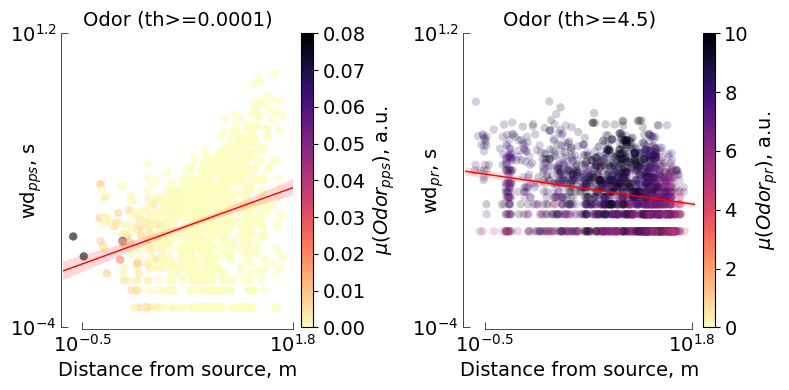

In [228]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='magma_r',edgecolors='none', 
                 alpha=0.6,vmin=0,vmax=0.08  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu(Odor_{pps})$, a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('wd$_{pps}$, s')
ax1.set_title('Odor (th>=0.0001)')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='magma_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu(Odor_{pr})$, a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s')
ax2.set_title('Odor (th>='+str(th)+')')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-4,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-0.5,1.8],
                            yticks=[-4,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-4}$',r'$10^{1.2}$'])
ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-4}$',r'$10^{1.2}$'])
ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()
